In [214]:
import os
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [249]:
class VAE (nn.Module):
    def __init__ (self, latent_dim):
        super (VAE, self).__init__ ()
        self.latent_dim = latent_dim
        
        self.encoder_conv = nn.Sequential (
            nn.Conv2d (1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU (),
            nn.Conv2d (32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU (),
            nn.Conv2d (64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU ()
        )
        
        self.fc_mu = nn.Linear (128*7*7, latent_dim)
        self.fc_logvar = nn.Linear (128*7*7, latent_dim)
        self.decoder_fc = nn.Linear (latent_dim, 128*7*7)
        
        self.decoder_conv = nn.Sequential (
            nn.ConvTranspose2d (128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU (),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU (),
            nn.Conv2d (32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid ()
        )
    
    def encode (self, x):
        h = self.encoder_conv (x)
        h = h.view (-1, 128*7*7)
        mu = self.fc_mu (h)
        logvar = self.fc_logvar (h)
        return mu, logvar
    
    def reparameterize (self, mu, logvar):
        std = torch.exp (0.5 * logvar)
        eps = torch.randn_like (std)
        return mu + eps * std
    
    def decode (self, z):
        h = self.decoder_fc (z)
        h = h.view (-1, 128, 7, 7)
        x_hat = self.decoder_conv (h)
        return x_hat
    
    def forward (self, x):
        mu, logvar = self.encode (x)
        z = self.reparameterize (mu, logvar)
        x_hat = self.decode (z)
        return x_hat, mu, logvar

In [216]:
def loss_function(x_hat, x, mu, logvar):
    BCE = F.binary_cross_entropy (x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum (1 + logvar - mu.pow (2) - logvar.exp ())
    return BCE + KLD

In [217]:
def generate_new_data (model, latent_dim, num_samples=1):
    z = torch.randn (num_samples, latent_dim).to (torch.device ('mps'))

    model.eval ()
    with torch.no_grad ():
        generated_data = model.decode (z)
    
    return generated_data

In [218]:
device = torch.device ('mps')

In [219]:
from dataclasses import dataclass

@dataclass
class VAEConfig:
    def __init__ (self, **kwargs):
        for k, v in kwargs.items ():
            setattr (self, k, v)

In [220]:
config = VAEConfig (
    latent_dim = 20,
    learning_rate = 1e-3,
    batch_size = 128,
    num_epochs = 50
)

In [221]:
transform = transforms.Compose ([
    transforms.ToTensor (),
])

In [222]:
train_dataset = datasets.MNIST ('./data', train=True, download=True, transform=transform)
train = DataLoader (train_dataset, batch_size=config.batch_size, shuffle=True)

In [223]:
vae = VAE (config.latent_dim).to (device)
optimizer = optim.Adam (vae.parameters (), lr=config.learning_rate)

In [224]:
path = os.path.join ("vit-cat-dog", "dogs", 'dog2.jpg')
image = Image.open (path)

test_transform = transforms.Compose ([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

dog = test_transform (image)

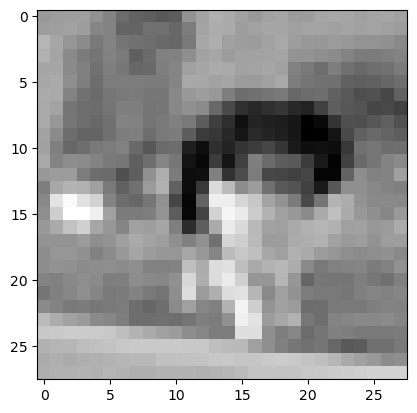

In [225]:
plt.imshow (dog.permute (1, 2, 0), cmap='gray')

In [226]:
dog.shape

torch.Size([1, 28, 28])

In [227]:
out_conv = nn.Sequential (
    nn.Conv2d (1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU (),
    nn.Conv2d (32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU (),
    nn.Conv2d (64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU ()
) (dog)
out_conv, out_conv.shape

(tensor([[[0.0567, 0.0293, 0.0272,  ..., 0.0319, 0.0324, 0.0325],
          [0.1041, 0.0420, 0.0423,  ..., 0.0564, 0.0540, 0.0438],
          [0.1002, 0.0404, 0.0531,  ..., 0.0469, 0.0358, 0.0383],
          ...,
          [0.1255, 0.0432, 0.0360,  ..., 0.0583, 0.0508, 0.0544],
          [0.0981, 0.0501, 0.0546,  ..., 0.0602, 0.0511, 0.0469],
          [0.0982, 0.0510, 0.0588,  ..., 0.0505, 0.0476, 0.0393]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0430, 0.0362, 0.0405,  ..., 0.0358, 0.0414, 0.0481],
          [0.0083, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0046, 0.0000, 0.0000,  ...,

In [228]:
out_view = out_conv.view (-1, 7 * 7 * 128)
out_view, out_view.shape

(tensor([[0.0567, 0.0293, 0.0272,  ..., 0.0133, 0.0016, 0.0000]],
        grad_fn=<ViewBackward0>),
 torch.Size([1, 6272]))

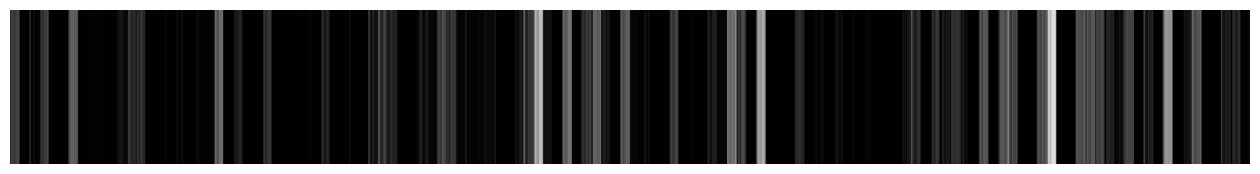

In [229]:
flattened_tensor_large = out_conv.view (-1, 128 * 7 * 7)

def plot_flattened_tensor (tensor):
    fig, ax = plt.subplots (figsize=(16, 2))
    ax.imshow (tensor.detach ().numpy (), cmap='gray', aspect='auto')
    ax.axis ('off')
    plt.show ()

plot_flattened_tensor (flattened_tensor_large)

In [230]:
vae.train ()
for epoch in range (config.num_epochs):
    total_loss = 0
    
    for batch_idx, (data, _) in enumerate (train):
        data = data.to (device)
        optimizer.zero_grad ()
        
        x_hat, mu, logvar = vae (data)
        
        # Flatten images for BCE loss
        data_flat = data.view(-1, 28*28)
        x_hat_flat = x_hat.view(-1, 28*28)
        
        # Normalize target to [0, 1]
        x_flat = (data_flat + 1) / 2  # Normalize to [0, 1] assuming data is in range [-1, 1]
        
        loss = loss_function(x_hat_flat, x_flat, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}')

# Generating new data after training
num_samples = 10
generated_data = generate_new_data (vae, latent_dim, num_samples)

# Plotting generated data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_data[i][0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [231]:
def reparameterize (mu, logvar):
    std = torch.exp (0.5*logvar)
    eps = torch.randn_like (std)
    return mu + eps*std

In [257]:
a = torch.zeros (40)
b = torch.ones (40)

In [258]:
reparameterize (a, b)

tensor([-4.7094, -2.5759, -0.3658, -0.6118, -2.9862,  3.7623, -0.9119,  1.2241,
        -0.5646, -0.5174,  1.1145,  3.5324, -2.8324,  0.0091, -0.4311, -0.2477,
        -4.0854, -0.6817,  0.7832,  0.6783,  2.4023,  1.1199, -3.4405, -0.3307,
         0.4612,  1.8913, -0.1054,  0.5410,  0.0702,  2.5726,  1.5809, -0.1346,
        -0.3741,  1.0383,  2.9701, -0.6717, -0.2890,  1.3937,  0.5703,  1.5218])

In [247]:
x = (20 - 10) * torch.rand (10, 10) + 10
x

tensor([[14.8258, 12.4205, 19.3737, 18.2561, 10.6344, 11.4893, 10.4944, 15.2086,
         14.8585, 14.0934],
        [19.1288, 16.9847, 17.3665, 15.9921, 13.0765, 13.2901, 11.6719, 16.5352,
         18.1949, 11.3472],
        [14.2734, 19.7863, 18.1235, 13.6099, 13.2407, 11.1440, 13.0158, 13.8744,
         17.4621, 17.9013],
        [18.4947, 19.8714, 13.6002, 17.2460, 10.2529, 16.5637, 18.1103, 13.1986,
         17.2880, 11.1360],
        [15.2162, 14.2677, 13.0893, 14.2468, 13.4644, 18.5001, 18.3924, 19.0874,
         19.6144, 17.5615],
        [19.4367, 15.5745, 17.8067, 15.3638, 11.1178, 10.9887, 12.8448, 12.9396,
         15.2665, 14.1989],
        [15.5880, 18.7961, 19.2214, 15.0851, 15.7373, 17.1132, 10.7115, 12.4199,
         16.7938, 10.0939],
        [15.1863, 15.4671, 16.5601, 17.8274, 14.6480, 16.0483, 12.1313, 13.0814,
         19.3257, 18.4800],
        [14.7987, 13.9356, 15.0813, 13.1028, 14.4581, 14.7220, 12.7557, 14.2984,
         16.5816, 19.2064],
        [14.3475, 1

In [252]:
torch.randn_like (x)

tensor([[ 1.1494e+00, -3.6645e-02,  1.0251e+00,  1.8176e+00, -1.2479e-01,
          3.7191e-01,  1.2734e+00,  2.2714e-01, -2.4099e+00, -2.5095e-01],
        [-7.8955e-01,  1.8246e+00,  2.8170e-02, -6.3706e-01, -1.2799e+00,
          1.0609e+00,  1.5255e+00,  1.5236e+00, -2.1197e-01,  2.2186e+00],
        [ 9.6262e-01,  1.1779e+00,  6.9597e-01, -7.1499e-01,  9.5591e-01,
         -7.0545e-01, -2.3781e+00,  1.5797e+00,  1.6647e+00, -1.4540e-03],
        [ 3.1488e-01,  1.6944e-03,  1.0143e+00, -5.8613e-01,  1.4507e+00,
          4.8753e-01,  1.2657e+00,  2.6088e-01,  1.3846e-01, -8.8478e-03],
        [ 7.4950e-01,  2.2930e+00, -1.4765e+00, -1.6427e+00,  3.2810e+00,
         -1.1166e-01,  1.7550e+00, -1.4364e-01, -9.9819e-02, -1.2584e+00],
        [ 9.1118e-01, -8.3829e-01, -1.9039e+00,  9.4556e-01, -2.3029e-01,
          1.4876e+00,  7.8266e-01,  1.0418e-01,  2.3312e+00, -6.8192e-01],
        [ 3.6506e-01,  3.3351e-01,  2.0611e-01, -1.9461e+00, -6.8130e-01,
          7.5960e-01,  1.2117e+0